<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1.0 !important; }</style>';
</script>
<!--# STAT 207: Data Science Exploration-->


## Classification and ROC Analysis

The previous section explored logistic regression as a tool for modeling the dependence of a binary response variable on other exogenous variables. Once a the model is built, it is possible to use it for prediction purposes, by viewing the logistic regression model as a **classification algorithm**. In this usage, the estimated probabilities (fitted values) from the logistic regression model provide scores that can be thresholded to create a 0/1 classfier.

For example, suppose we have a model that provides a probability of rain each day. We might view a fitted probability greater than or equal to 50% as a prediction of rain, and a fitted probability less than 50% as a prediction of no rain. 

How good is the classifer? The confusion matrix provides a way to keep track of the performance by cross classifying the true and predicted classes. From the confusion matrix we can compute:

+ **Sensitivity:** fraction of true positives that are called positive by the algorithm for a given threshold;

+ **Specificity:** fraction of true negatives that are called negative by the algorithm for a given threshold.

The **ROC curve** provides an overall summary of how good a scoring system across all possible thresholds, by graphing sensitivity versus 1 - specificity. This can also be used to find the optimal threshold.


**New package: scikit-learn - machine learning package**

To install this on your computer enter the following command from a terminal or anaconda window:

    conda install scikit-learn
 


### Classification with logistic regression: simulation example

#### First we generate some data

In [1]:
import numpy as np
import pandas as pd
import zipfile as zp

In [2]:
from scipy.stats import norm, bernoulli

In [3]:
# set the coefficient values
b0, b1 = -0.7, 2.1  
#
# generate exogenous variable
x = norm.rvs(size=100, random_state=12347)
#
# odds depend on x
odds = np.exp(b0 + b1*x)   
#
# convert odds to probabilities, generate response y
y = bernoulli.rvs(p=odds/(1+odds), size=100, random_state=1)
dat = pd.DataFrame({'x':x, 'y':y})
dat.head(10)

,x,y
0,0.343687,1
1,1.848400,1
2,0.224359,0
3,-1.633660,0
4,1.245538,1
5,1.712812,1
6,-0.687918,0
7,-1.186239,0
8,-0.400249,0
9,-0.303626,0


#### Given the data we fit a model

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
simmod = smf.logit('y ~ x', data=dat).fit()
simmod.summary()

Optimization terminated successfully.
         Current function value: 0.403715
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                  0.4149
Time:                        11:35:02   Log-Likelihood:                -40.371
converged:                       True   LL-Null:                       -68.994
                                        LLR p-value:                 3.846e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4938      0.291     -1.697      0.090      -1.064       0.076
x              2.2133      0.440      5.028      0.000       1.350       3.076
==============================================================================
"""

#### Prediction based on the model: predictive probabilities

In [6]:
# example predictive probabilities
simmod.predict(exog=dict(x=[-2,-1,0,1,2])) 

0    0.007243
1    0.062554
2    0.378988
3    0.848056
4    0.980786
dtype: float64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

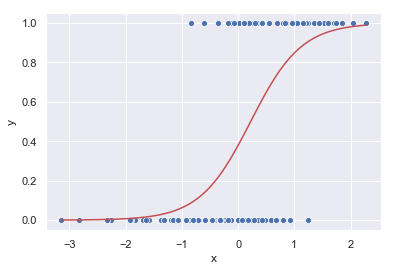

In [8]:
# scatter plot of raw 0/1 data
sns.scatterplot(x='x', y='y', data=dat)
#
# make a grid of x values for the probability curve
xgrid = np.linspace(dat['x'].min(), dat['x'].max(), 100)
#
# get predictive probabilities for the grid
pgrid = simmod.predict(exog=dict(x=xgrid))
#
# add the curve to the plot
plt.plot(xgrid, pgrid, color='r') 
plt.show()

#### Classification threshold derived from predictive probability

How accurate is this model as a classifier? It depends in part on where we set the threshold. Let $\hat{p}(x)$ denote the estimated probability as a function of $x$. Suppose our classification rule is  $I(\hat{p} > p_0)$ where $I(True)=1$ and $I(False)=0$. Because the fitted probability function is increasing as a function of x, the probability threshold is equivalent to a threshold for $x$.

First, the logit of the threshold is 

$$
\log\left({p_0 \over 1-p_0}\right).
$$

Furthermore, the fitted model has the form

$$
\log\left({\hat{p} \over 1 - \hat{p}}\right) = \hat{\beta}_0 + \hat{\beta}_1 x
$$

Setting this equal to the threshold logit and solving for $x$ gives the classifier threshold:

$$
x_{0} = {\mbox{logit}(p_0) -\hat{\beta}_0 \over \hat{\beta}_1}
$$


If we set $p_0=0.5$, a common default, then $\mbox{logit}(p_0)=0$ and the threshold is simply

$$
x_0 = - { \hat{\beta}_0 \over \hat{\beta}_1 }.
$$

#### Exploring different classification thresholds

In [9]:
simmod.params

Intercept   -0.493845
x            2.213281
dtype: float64

In [10]:
#### Set probability threshold
pthresh = 0.50

In [11]:
#### Compute corresponding x threshold
xthresh = (np.log(pthresh/(1-pthresh)) \
           -simmod.params[0])/simmod.params[1]
xthresh

0.22312813097265544

In [12]:
#### Predicted y based on threshold
dat['yhat'] = 1*(dat['x'] >= xthresh)
dat.head()

,x,y,yhat
0,0.343687,1,1
1,1.848400,1,1
2,0.224359,0,1
3,-1.633660,0,0
4,1.245538,1,1


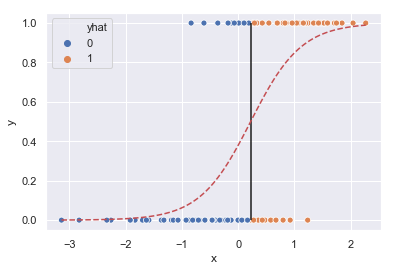

In [13]:
# scatter plot of raw 0/1 data
sns.scatterplot(x='x', y='y', hue='yhat', data=dat)
#
# make a grid of x values for probability curve
xgrid = np.linspace(dat['x'].min(), dat['x'].max(), 100)
#
# get predictive probabilities for the grid
pgrid = simmod.predict(exog=dict(x=xgrid))
#
# add probability curve to the graph
plt.plot(xgrid, pgrid, color='r', linestyle='dashed')
#
# add x threshold line for 0/1 classification
plt.vlines(x=xthresh, ymin=0, ymax=1)
plt.show()

How is the performance of the classifier on the training data? Because the 0's and 1's have overlapping $x$ values, no classifier based on $x$ only can perfectly classify them.


+ The orange colored observations with $y=1$ are correctly classified because they are above the $x$ threshold and therefore have $\hat{y}=1=y$.


+ The blue colored observations with $y=0$ are correctly classified because they are below the $x$ threshold and therefore $\hat{y}=0=y$.


+ The blue colored observations with $y=1$ and the orange colored observations with $y=0$ are incorrectly classified because $\hat{y} \ne y$.



#### Confusion matrix, sensitivity and specificity

We can summarize the classification performance for a given classifier by comparing the predicted classes to the true classes. The we cross classify the results.



| Classification  | Actual Negative (0) | Actual Positive (1) |
| --- | --- | --- |
| Predicted Negative (0) | TN = True Neg | FN = False Neg |
| Predicted Positive (1) | FP = False Pos | TP = True Pos |

In [14]:
# This import requires that you already 
# installed the scikit-learn library 
# as described in the introduction to this chapter.
#
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [15]:
confusion_matrix(y_true=dat['y'], y_pred=dat['yhat'])

array([[44, 10],
       [10, 36]], dtype=int64)

In [16]:
tn, fp, fn, tp = confusion_matrix(y_true=dat['y'], 
                                  y_pred=dat['yhat']).ravel()
(tn, fp, fn, tp)

(44, 10, 10, 36)

In [17]:
# Sensitivity = true positive rate
tp / (fn + tp)

0.782608695652174

In [18]:
# Specificity = true negative rate
tn / (fp + tn)

0.8148148148148148

Sensitivity and specificity are commonly used measures of classification performance. They play against each other in that we can increase one or the other of them by changing the classfiication threshold, but it will be at the cost of decreasing the other.

#### ROC Curve, plotting sensitivity and specificity across all thresholds.

The ROC curve provides a look at the inherent classification ability of a given scoring system, independently of where one sets the threshold on the scores. There will then be an optimal threshold based on the desired tradeoff, which may be deduced from the ROC curve.

In [19]:
fpr, tpr, score = roc_curve(y_true=dat['y'], 
                            y_score=simmod.fittedvalues)
auc = roc_auc_score(y_true=dat['y'], 
                    y_score=simmod.fittedvalues)

**Plotting function for ROC curve:** 

Let's define a function for plotting the ROC curve taking the arrays of false postive rates and true positive rates as arguments. (Modified from: https://stackabuse.com/understanding-roc-curves-with-python/)

In [20]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
             label='ROC curve (area = '+str(round(auc,3))+')')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

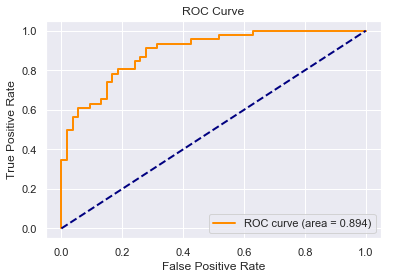

In [21]:
plot_roc(fpr, tpr, auc)

### ROC/AUC summary

The area under the curve (AUC) is one metric of the amount of information in a classification scoring system. It shows how the true positive and false positive rates track as we change the threshold in the scoring system from a maximum to a minimum possible threshold. 

The curve captures the trade-off between **sensitivity (TP rate)** and **1 - specificity (1 - TN rate)** as the threshold changes.

The baselines for comparison are:

+ Random guessing: its ROC curve is represented by the diagonal dashed line, and its AUC = 0.50.


+ Perfect classification: Its ROC curve would jump up to a true positive rate of 1 at a false positive rate of 0; its ASUC = 1


+ In our example, AUC = 0.89, which is pretty high depending on the context.




### Example: Predicting responses to Q52 in the Pew survey - using different features.

In [22]:
zf = zp.ZipFile('../data/Feb17-public.zip')
missing_values = ["NaN", "nan", "Don't know/Refused (VOL.)"]
df = pd.read_csv(zf.open('Feb17public.csv'),
                 na_values=missing_values)[['age', 'sex', \
                                            'q52', 'party']]

In [23]:
# reduce q52 responses to two categories and 
# create binary reponse variable
df['q52'][df['q52']!='Favor'] = 'Not_favor'
df['y'] = df['q52'].map({'Not_favor':0,'Favor':1})
#
# use cleaned data without records that have missing values
dfclean = df.dropna()
dfclean.head(10)

,age,sex,q52,party,y
0,80.0,Female,Not_favor,Independent,0
1,70.0,Female,Not_favor,Democrat,0
2,69.0,Female,Not_favor,Independent,0
3,50.0,Male,Favor,Republican,1
4,70.0,Female,Not_favor,Democrat,0
5,78.0,Male,Not_favor,Democrat,0
6,89.0,Female,Not_favor,Independent,0
7,92.0,Female,Not_favor,Republican,0
8,54.0,Female,Favor,Independent,1
9,58.0,Female,Not_favor,Independent,0


#### Using age and gender for predictive probability modeling

In [24]:
mod1 = smf.logit('y ~ age + sex', data=dfclean).fit()
mod1.summary()

Optimization terminated successfully.
         Current function value: 0.619057
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1465
Model:                          Logit   Df Residuals:                     1462
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                 0.03557
Time:                        11:35:04   Log-Likelihood:                -906.92
converged:                       True   LL-Null:                       -940.37
                                        LLR p-value:                 2.960e-15
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.0818      0.196    -10.637      0.000      -2.465      -1.698
sex[T.Male]     0.5415      0.114      4.750      0.000       0.318       0.765
age             0.0220      0.003      6.770      0.000       0.016       0.028
===============================================================================
"""

In [25]:
fpr, tpr, score = roc_curve(y_true=dfclean['y'], 
                            y_score=mod1.fittedvalues)
auc = roc_auc_score(y_true=dfclean['y'], 
                    y_score=mod1.fittedvalues)

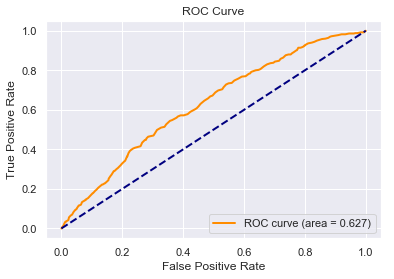

In [26]:
plot_roc(fpr, tpr, auc)

**Conclusion:** We see that although 'age' and 'sex' are statistically signficant variables in the model, using only these variables to predict 'y' is not much better than random guessing. There is too much variation beyond that explained by age and gender to rely on them for accurate classfication.

#### Including party affiliation as a predictor

Let's see what happens if we add 'party' to the model as an additional explanatory variable.

In [27]:
mod2 = smf.logit('y ~ party + age + sex', data=dfclean).fit()
mod2.summary()

Optimization terminated successfully.
         Current function value: 0.466129
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1465
Model:                          Logit   Df Residuals:                     1458
Method:                           MLE   Df Model:                            6
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                  0.2738
Time:                        11:35:04   Log-Likelihood:                -682.88
converged:                       True   LL-Null:                       -940.37
                                        LLR p-value:                4.971e-108
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.5261      0.281    -12.536      0.000      -4.077      -2.975
party[T.Independent]              1.6843      0.191      8.796      0.000       1.309       2.060
party[T.No preference (VOL.)]     1.8226      0.379      4.807      0.000       1.079       2.566
party[T.Other party (VOL.)]       2.8930      0.938      3.083      0.002       1.054       4.732
party[T.Republican]               3.5862      0.206     17.435      0.000       3.183       3.989
sex[T.Male]                       0.3721      0.137      2.712      0.007       0.103       0.641
age                               0.0168      0.004      4.305      0.000       0.009       0.024
=================================================================================================
"""

Note that including 'party' entails that a few more of the rows have missing information than when we only included 'age' and 'sex'. 

In [28]:
fpr, tpr, score = roc_curve(y_true=dfclean['y'], 
                            y_score=mod2.fittedvalues)
auc = roc_auc_score(y_true=dfclean['y'], 
                    y_score=mod2.fittedvalues)

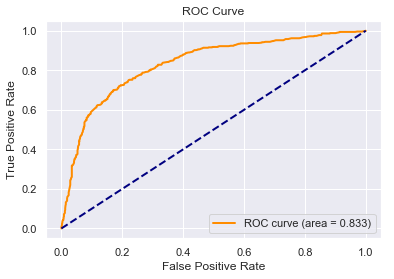

In [29]:
plot_roc(fpr, tpr, auc)

**Conclusion:** It appears that including party affiliation in the model gives a big improvement in the ability of the model to predict the answer to 'q52', increasing the area under the curve from 0.63 to 0.83. There is still substantial variation remaining. 

For example, if we set the threshold for a false positive rate of 0.2 (specificity = 0.8), then the sensitivity is around 0.75. If we set the threshold sensitivity at 0.8, then the false positive rate is 0.3 (specificity = 0.7). We see that peoples' opinions are more than just the sum of their age, gender and party affiliation.

---
STAT 207, Douglas Simpson, University of Illinois at Urbana-Champaign